In [ ]:
# Import Packages
import time
import torch
import numpy as np 
import matplotlib.pyplot as plt
import torch.cuda as cuda
import pickle
from tensorflow.python.client import device_lib
from google.colab import drive

# Import My Modules 
from snake_class import Agent 
from food_class import meal, food_init
from network import net

drive.mount('/content/drive')

memory = {} # The Replay Memory
memory_pointer = 0 

lr = 0.001

reward_food = 100
reward_loose = -100
reward_move = -0.1

features = 8 # Number of features

gamma = 0.99
batch_size = 128
M = 30000 # Number of Episodes

ep_min = 0.0001
delta_ep = 0.00001
e = 1 # The initial epsilon

dimension = 10 + 2

max_memory_size = 50000
target_update = 10
total_steps = 0

action_to_direction = {0:"Left" , 1:"Right", 2:"Up", 3:"Down"}


print(device_lib.list_local_devices()) # Show the GPU & CPU Specifications


Mounted at /content/drive
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2785364831050025199
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8374941654167369024
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7214572898068590558
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14618221632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16840787413689311114
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


In [ ]:
# Network

Q_policy=net(features,4) # Q_theta
Q_target=net(features,4) # Q_theta-

Q_target.load_state_dict(Q_policy.state_dict())
Q_target.eval()

Q_target.double()
Q_policy.double()


criterion=torch.nn.MSELoss()
optimizer=torch.optim.RMSprop(Q_policy.parameters(), lr=lr)

if cuda.is_available():
          Q_policy = Q_policy.cuda()
          Q_target = Q_target.cuda()



In [ ]:
# Training

from functions import return_state, return_batch_X, cal_Y, epsilon_greedy

start_time = time.time() 
end = 0 # Not end
total_steps = 0
scores = []
counter = 200 # Counter of saving networks and showing the result

for episode in range(1, M+1):
    if episode % counter == 0  :
        # print(total_steps)
        print("Episode {0:5d} started -->".format(episode),end="  ")
        if total_steps < 2000:
          print(" No Training")

    # Initializing the snake and food positions
    snake= Agent(dimension)
    food,_ = food_init(dimension,snake.path)    
    current_state = return_state(snake.path , food)  #  np array ([1, features])  
    
    loose = False # Loose : Snake runs into the wall or runs into itslef
    isFinished = False # The game ends when the snake eats all the foods

    Losses = 0
    step = 0
    score = 0 

    while loose != True: # Not loose

        tensor_current_state = torch.from_numpy(current_state)
        if cuda.is_available():
          tensor_current_state = tensor_current_state.cuda()
        
        Q_policy.eval()
        with torch.no_grad():
          out = Q_policy(tensor_current_state)

        best_action = int(torch.argmax( out ))

        action = epsilon_greedy(best_action) # action is 0, 1, 2 or 3 
    
        snake.move(action_to_direction[action],dimension)
        step += 1
        total_steps += 1

        if snake.head[0] == food.x and snake.head[1] == food.y:  # Eating food
            score += 1
            reward = reward_food
            food, isFinished = food_init(dimension,snake.path) # Initializing the food position
            loose = isFinished
            end = int(isFinished)
            new_state = return_state(snake.path , food) #  np array ([1, features])  

   
        elif snake.head in snake.path[1:-1]: # Loose : runs into itself
            loose = True
            reward = reward_loose
            end = 1 # True
            snake.path.pop(0) # Removing the tail
            new_state = return_state(snake.path , food)  #  np array ([1, features])  
            scores.append(score)
           
            
        elif (snake.head[0] in [0,dimension-1]) or (snake.head[1] in [0,dimension-1]): # Loose : runs into the wall
            loose = True
            reward = reward_loose
            end = 1 # True
            snake.path.pop(0) # Removing the tail
            new_state = return_state(snake.path , food)  #  np array ([1, features])  
            scores.append(score)
        
        else : # Just moved
            reward = reward_move
            end = 0 # False
            snake.path.pop(0) # Removing the tail
            new_state = return_state(snake.path , food)  #  np array ([1, features])  

        #### save in memory ###
        if memory_pointer < (max_memory_size-1):
                  memory[memory_pointer] = [current_state, action, reward, new_state,end]
        else :
                  memory_pointer = 0
                  memory[memory_pointer] = [current_state, action, reward, new_state,end]
        memory_pointer += 1

        if total_steps > 2000: # Training will start after the first 2000 steps
          X, indexes = return_batch_X(memory) #  X : torch.Size([batch_size, features])   
          if cuda.is_available():
            X = X.cuda()

          Q_policy.train()
          outputs = Q_policy(X) # output: torch.Size([batchsize, 4]) | 4 is number of output neurons
          actions = [[memory[i][1]] for i in indexes] # contains actions of mini-batch stored in the memory
          
          tensor_actions = torch.tensor(actions)
          if cuda.is_available():
                    tensor_actions = tensor_actions.cuda()

          outputs = torch.gather(outputs, 1, tensor_actions ) # outputs :  torch.Size([batch_size , 1])      

          Y = cal_Y(indexes,memory) # Y :  torch.Size([batch_size , 1])

          if cuda.is_available():
            Y = Y.cuda()

          loss = criterion(outputs,Y.detach())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          Losses += loss.data
          current_state = new_state.copy()
          if (loose == True) :
              if episode % counter == 0:
                print("Total Transitions(Until end of this episode) : {0:7d}".format(total_steps),end=" | ")
                print("Transitions(this episode) : {0:3d}".format(step),end=" | ")
                print("Score : {0:2d}".format(score),end=" | ")
                print("Loss : {0:.3f}".format(Losses/step),end=" | ")
                print("Mean scores of last {0} episodes : {1:.3f}".format(1000,np.mean(scores[-1000:])))

              # begin the next episode
        

    if total_steps % target_update == 0 :
            Q_target.load_state_dict(Q_policy.state_dict())
    

    if episode % counter == 0:
       PATH="/content/drive/My Drive/policy_network.pth"
       torch.save({
              'Q_policy_state_dict': Q_policy.state_dict()  
              }, PATH)

print("**** Finished in ~ {} Minutes".format(int((time.time() - start_time)/60)))

Episode   200 started -->   No Training
Episode   400 started -->   No Training
Episode   600 started -->   No Training
Episode   800 started -->  Total Transitions(Until end of this episode) :    2498 | Transitions(this episode) :   2 | Score :  0 | Loss : 1182.174 | Mean scores of last 1000 episodes : 0.018
Episode  1000 started -->  Total Transitions(Until end of this episode) :    3058 | Transitions(this episode) :   4 | Score :  0 | Loss : 5001.195 | Mean scores of last 1000 episodes : 0.017
Episode  1200 started -->  Total Transitions(Until end of this episode) :    3723 | Transitions(this episode) :   1 | Score :  0 | Loss : 9157.743 | Mean scores of last 1000 episodes : 0.018
Episode  1400 started -->  Total Transitions(Until end of this episode) :    4368 | Transitions(this episode) :   5 | Score :  0 | Loss : 16585.086 | Mean scores of last 1000 episodes : 0.018
Episode  1600 started -->  Total Transitions(Until end of this episode) :    5049 | Transitions(this episode) :   1

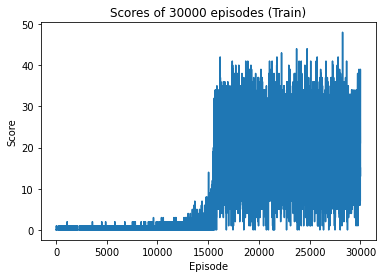

In [ ]:
# Plot the scores
x = [i for i in range(1,M+1)]
y = scores
plt.plot(x,y)
plt.title("Scores of {} episodes (Train)".format(M))
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()